<a href="https://colab.research.google.com/github/MaximeSzymanski/VAE_pytorch/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
# get mnist dataÀà

import torchvision
from torchvision import datasets, transforms


In [2]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
def image_to_tensor(image_path):
    img = Image.open(image_path).convert('RGB')
    resize = transforms.Resize((64, 64))
    img = resize(img)
    img = transforms.ToTensor()(img)
    return img

# get all path in the folder and subfolders
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

folder = 'vae_mc_dataset/tensors'
# get all file apth in the folder
files = []
for r, d, f in os.walk(folder):
    for file in f:
        if '.png' in file:
            files.append(os.path.join(r, file))
print(f"Number of files: {len(files)}")
list_dataset = []
for file in files:
    list_dataset.append(image_to_tensor(file))
tranining_dataset = torch.stack(list_dataset)

Number of files: 3236


size of the dataset: torch.Size([3236, 3, 64, 64])


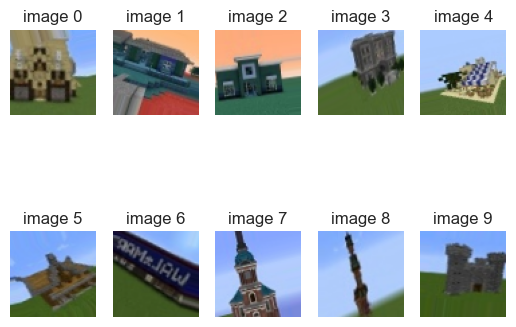

In [3]:
print(f'size of the dataset: {tranining_dataset.shape}')
# plot the 10 first images
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(tranining_dataset[i].permute(1,2,0))
    plt.axis('off')
    plt.title(f"image {i}")

In [4]:
# keep only percentage of the training set
percentage = 0.01
n = int(percentage*len(tranining_dataset))
print(f"number of images kept: {n}")
training_dataset = tranining_dataset[:n]


number of images kept: 32


In [5]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder,self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        # relu
        # pooling
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # relu
        # pooling
        # flatten
        self.fc1 = torch.nn.Linear(64*16*16, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, latent_dim)


    def forward(self, x):
        # x: batch_size * 1 * 28 * 28
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # x: batch_size * 32 * 28 * 28
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # x: batch_size * 64 * 28 * 28
        # flatten
        print(f"shape before flatten: {x.shape}")
        x = x.view(-1, 64*16*16)
        # x: batch_size * 64*7*7
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * hidden_dim
        x = self.fc2(x)
        # x: batch_size * latent_dim
        return x

In [6]:
encoder = Encoder(1, 128, 2)

In [7]:
first_imgae = training_dataset[0].unsqueeze(0)
encoded = encoder(first_imgae)
print(f"shape of the encoded image: {encoded.shape}")

shape before flatten: torch.Size([1, 64, 16, 16])
shape of the encoded image: torch.Size([1, 2])


shape before flatten: torch.Size([10, 64, 16, 16])
shape before flatten: torch.Size([10, 64, 16, 16])


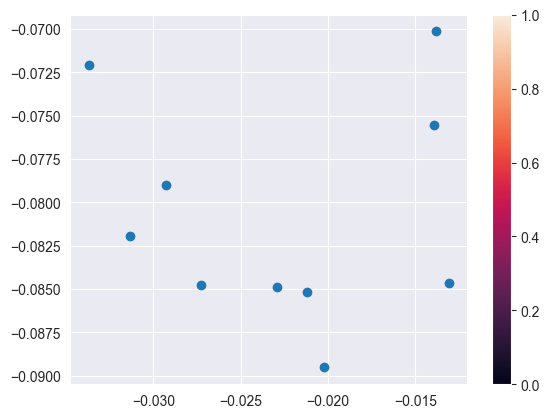

In [8]:
# encode the first 10 images
images = training_dataset[:10]
encoder(images)
# plot the encoded images in 2D
encoded_images = encoder(images).detach().numpy()
plt.scatter(encoded_images[:, 0], encoded_images[:, 1])
plt.colorbar()
plt.show()

In [9]:
class SamplingLayer(torch.nn.Module):
    def __init__(self):
        super(SamplingLayer, self).__init__()

    def forward(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

class VariationalEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalEncoder, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(8)  # Batch Normalization after the first convolution
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(16)  # Batch Normalization after the second convolution
        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(32)  # Batch Normalization after the third convolution

        self.fc1 = torch.nn.Linear(2048, hidden_dim)
        self.mu = torch.nn.Linear(hidden_dim, latent_dim)
        self.logvar = torch.nn.Linear(hidden_dim, latent_dim)
        self.sampling = SamplingLayer()
        # init logvar to 0
        self.logvar.weight.data.fill_(0)
        self.logvar.bias.data.fill_(0)

    def forward(self, x):
        original_x = x
        x = self.conv1(x)
        x = self.bn1(x)  # Apply Batch Normalization
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = self.conv2(x)
        x = self.bn2(x)  # Apply Batch Normalization
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = self.conv3(x)
        x = self.bn3(x)  # Apply Batch Normalization
        x = torch.nn.functional.leaky_relu(x, 0.2)

        x = torch.nn.Flatten(start_dim=1)(x)
        # x: batch_size * 64*7*7
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * hidden_dim
        mu = self.mu(x)
        sigma = self.logvar(x)
        z = self.sampling(mu, sigma)
        # print the shape
        """print(f'original_x: {original_x.shape}')
        print(f'mu: {mu.shape}')
        print(f'sigma: {sigma.shape}')
        print(f'z: {z.shape}')"""

        # x: batch_size * latent_dim
        return z, mu, sigma, original_x

class VariationalDecoder(torch.nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(VariationalDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.fc1 = torch.nn.Linear(latent_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 3 * 64 * 64)  # Adjust the output size

        # Transpose Convolutional layers
        self.t_conv1 = torch.nn.ConvTranspose2d(3, 32, kernel_size=3, stride=1, padding=1)  # Change input channels to 3
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.t_conv2 = torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1)  # Increase the number of output channels
        self.bn2 = torch.nn.BatchNorm2d(16)
        self.t_conv3 = torch.nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1)  # Change kernel size and stride


    def forward(self, x):
        batch_size = x.size(0)
        x = self.fc1(x)
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = self.fc2(x)
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = torch.nn.Unflatten(1, (3, 64, 64))(x)

        x = self.t_conv1(x)
        x = self.bn1(x)  # Apply Batch Normalization
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = self.t_conv2(x)
        x = self.bn2(x)  # Apply Batch Normalization
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = self.t_conv3(x)
        x = torch.nn.functional.sigmoid(x)

        return x



In [10]:
class VariationalAutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = VariationalEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = VariationalDecoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        z, mu, sigma, original_x = self.encoder(x)
        x = self.decoder(z)
        return x, mu, sigma, original_x

In [11]:
encoder = VariationalEncoder(1, 128, 64)

first_image = training_dataset[0].unsqueeze(0)
encoded_first_image,_,_,_ = encoder(first_image)
decoder = VariationalDecoder(64, 128, 1)
decoded = decoder(encoded_first_image)
print(f"shape of the decoded image: {decoded.shape}")

shape of the decoded image: torch.Size([1, 3, 64, 64])


In [12]:
def KL_loss(mu, sigma):
    return -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

def reconstruction_loss(original_x, x):


    return torch.nn.functional.binary_cross_entropy(x, original_x, reduction='sum')

def loss_function(x, original_x, mu, sigma,k1=1,k2=3e-5):

    return k1 *reconstruction_loss(original_x, x) + k2 * KL_loss(mu, sigma)

In [13]:

variational_autoencoder = VariationalAutoEncoder(1, 128, 64)

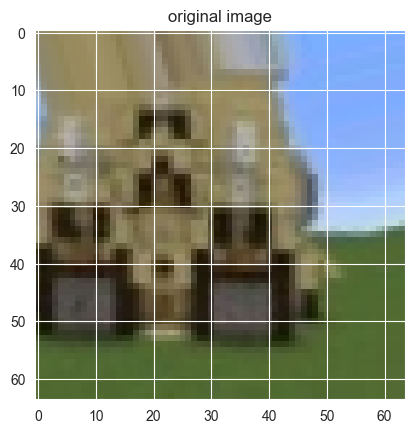

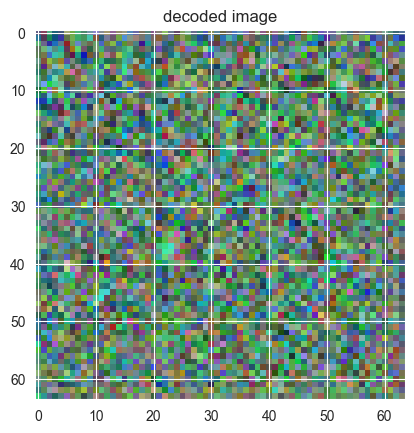

In [14]:
# encode the first 10 images
images = training_dataset[:10].float()
images = images.to(device)

encoded,_,_,_= variational_autoencoder.encoder(images)
decoded = variational_autoencoder.decoder(encoded)

# plot the original image, and the decoded images
plt.imshow(images[0].cpu().detach().permute(1, 2, 0))
# add title
plt.title("original image")
plt.show()
plt.imshow(decoded[0].cpu().detach().permute(1, 2, 0))
plt.title("decoded image")
plt.show()



In [15]:
print(variational_autoencoder)

VariationalAutoEncoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=2048, out_features=128, bias=True)
    (mu): Linear(in_features=128, out_features=64, bias=True)
    (logvar): Linear(in_features=128, out_features=64, bias=True)
    (sampling): SamplingLayer()
  )
  (decoder): VariationalDecoder(
    (fc1): Linear(in_features=64, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=12288, bias=True)
    (t_conv1): ConvTranspose2d(3, 32, kernel_s

In [16]:
batch_size = 64
lr = 1e-3
epochs = 10
optimizer = torch.optim.Adam(variational_autoencoder.parameters(), lr=lr)
# put data into dataloader
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

/var/folders/x7/9x2xrn891jxgf18qzxbzyd_m0000gn/T/ipykernel_59038/3716515997.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], legend='full', palette=sns.color_palette("hls", 10))


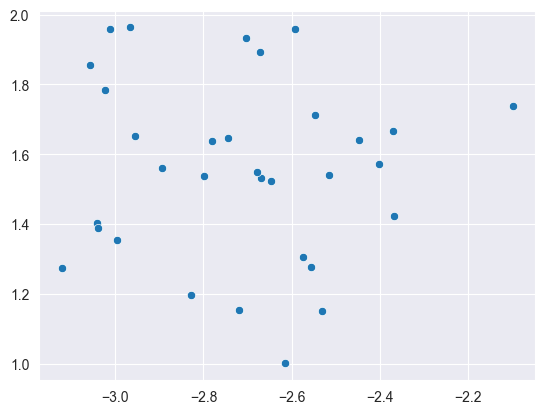

In [17]:
# check clusters using t-sne
from sklearn.manifold import TSNE
import seaborn as sns
with torch.no_grad():
    images = training_dataset.float()
    images = images.to(device)
    encoded = variational_autoencoder.encoder(images)
    decoded = variational_autoencoder.decoder(encoded[0])

    # Plot the encoded images in 2D and use contrasting colors
    encoded_images = encoded[0].cpu().detach().numpy()

encoded_data_2d = TSNE(n_components=2).fit_transform(encoded_images)
sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], legend='full', palette=sns.color_palette("hls", 10))
plt.show()

In [18]:
def train(epochs):
    for epoch in range(epochs):
        epoch_loss = 0

        for i, (images) in enumerate(training_dataloader):
            # plot the first image of the first batch

            # check if images is full of 0
            images = images.float()
            # count number of non 0 in the tensor


            images = images.to(device)
            x, mu, sigma, original_x = variational_autoencoder(images)
            original_x = original_x.detach()
            loss = loss_function(x, original_x, mu, sigma)

            epoch_loss += loss.mean().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {epoch_loss/len(training_dataloader.dataset)}')


In [19]:
train(1000)

Epoch: 1, Loss: 9565.283203125
Epoch: 2, Loss: 9312.3056640625
Epoch: 3, Loss: 9058.9208984375
Epoch: 4, Loss: 8801.453125
Epoch: 5, Loss: 8495.97265625
Epoch: 6, Loss: 8250.912109375
Epoch: 7, Loss: 8093.87255859375
Epoch: 8, Loss: 7989.90234375
Epoch: 9, Loss: 7916.13134765625
Epoch: 10, Loss: 7848.66064453125
Epoch: 11, Loss: 7786.50390625
Epoch: 12, Loss: 7753.4736328125
Epoch: 13, Loss: 7723.6455078125
Epoch: 14, Loss: 7700.12646484375
Epoch: 15, Loss: 7661.998046875
Epoch: 16, Loss: 7622.04443359375
Epoch: 17, Loss: 7582.7412109375
Epoch: 18, Loss: 7538.572265625
Epoch: 19, Loss: 7498.42041015625
Epoch: 20, Loss: 7465.79736328125
Epoch: 21, Loss: 7443.37548828125
Epoch: 22, Loss: 7422.68408203125
Epoch: 23, Loss: 7404.31689453125
Epoch: 24, Loss: 7382.31494140625
Epoch: 25, Loss: 7360.59130859375
Epoch: 26, Loss: 7339.072265625
Epoch: 27, Loss: 7322.67578125
Epoch: 28, Loss: 7307.50927734375
Epoch: 29, Loss: 7284.69482421875
Epoch: 30, Loss: 7264.35302734375
Epoch: 31, Loss: 7243

torch.Size([32, 3, 64, 64])


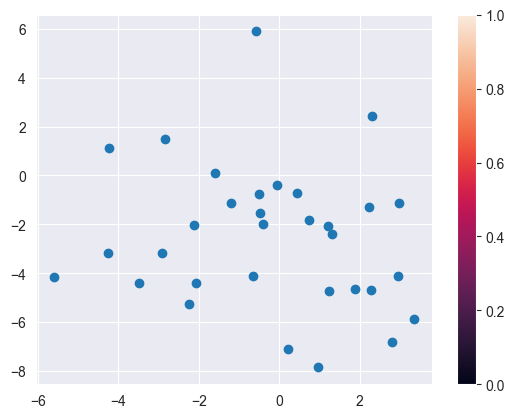

In [20]:
# take all images from the train set
with torch.no_grad():
  # encode the first 10 images
    print(training_dataloader.dataset.shape)
    images = training_dataloader.dataset.float()
    images = images.to(device)
    # plot the encoded images in 2D

    encoded_images, _ , _ ,_  = variational_autoencoder.encoder(images)
    encoded_images = encoded_images.cpu().detach().numpy()
    plt.scatter(encoded_images[:, 0], encoded_images[:, 1])
    plt.colorbar()
    plt.show()


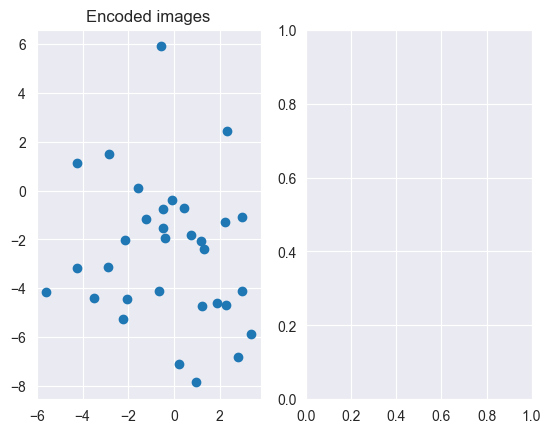

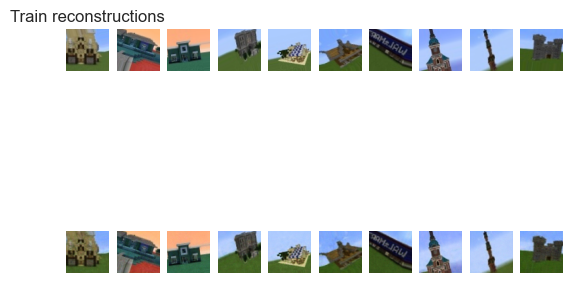

In [21]:
import torch
import matplotlib.pyplot as plt

# Take 10 images from the train set
with torch.no_grad():
    images = training_dataloader.dataset.float()
    images = images.to(device)
    encoded = variational_autoencoder.encoder(images)

    # Plot the encoded images in 2D and use contrasting colors
    encoded_images = encoded[0].cpu().detach().numpy()
    f, ax_arr = plt.subplots(1, 2)
    ax_arr[0].scatter(encoded_images[:, 0], encoded_images[:, 1])
    ax_arr[0].set_title('Encoded images')



    # Plot the decoded images in a 2 by 5 grid, with the original images on top of each decoded image
    f, axarr = plt.subplots(2, 10)

    # Get the first 10 images
    random_images_train = training_dataloader.dataset.float()[:10].float()
    random_images_train = random_images_train.to(device)
    # Encode the whole images
    encoded_train, _, _, _ = variational_autoencoder.encoder(random_images_train)

    decoded_train = variational_autoencoder.decoder(encoded_train)
    # Decode the whole images and plot them
    axarr[0, 0].set_title('Train reconstructions')

    for i in range(10):
        # Remove the axis ticks
        axarr[0, i].axis('off')
        axarr[1, i].axis('off')
        # name it train
        # Plot the original images in black and white
        axarr[0, i].imshow(random_images_train[i].cpu().detach().permute(1, 2, 0))

        axarr[1, i].imshow(decoded_train[i].cpu().detach().permute(1, 2, 0))


    # Do the same for the test set





In [22]:
# check clusters using t-sne
from sklearn.manifold import TSNE
import seaborn as sns
with torch.no_grad():
    images = mnist_testset.data.float().unsqueeze(1)
    images = images.to(device)
    encoded = variational_autoencoder.encoder(images)
    decoded = variational_autoencoder.decoder(encoded[0])

    # Plot the encoded images in 2D and use contrasting colors
    encoded_images = encoded[0].cpu().detach().numpy()

encoded_data_2d = TSNE(n_components=2).fit_transform(encoded_images)
sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], hue=mnist_testset.targets.numpy(), legend='full', palette=sns.color_palette("hls", 10))
plt.show()

NameError: name 'mnist_testset' is not defined

/var/folders/x7/9x2xrn891jxgf18qzxbzyd_m0000gn/T/ipykernel_59038/1962336135.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], legend='full', palette=sns.color_palette("hls", 10))


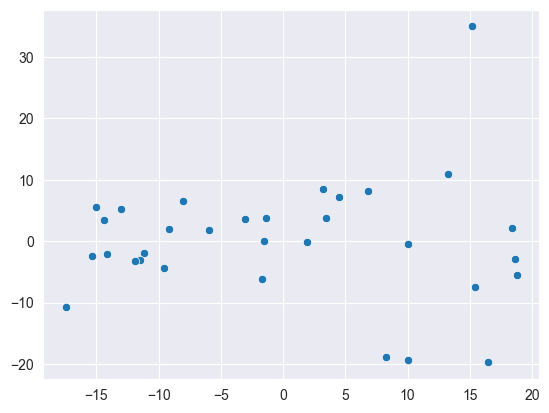

In [23]:
# do same with PCA
from sklearn.decomposition import PCA
with torch.no_grad():
    images = training_dataloader.dataset.float()
    images = images.to(device)
    encoded = variational_autoencoder.encoder(images)

    # Plot the encoded images in 2D and use contrasting colors
    encoded_images = encoded[0].cpu().detach().numpy()

encoded_data_2d = PCA(n_components=2).fit_transform(encoded_images)
sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], legend='full', palette=sns.color_palette("hls", 10))
plt.show()

shape : torch.Size([1, 3, 64, 64])


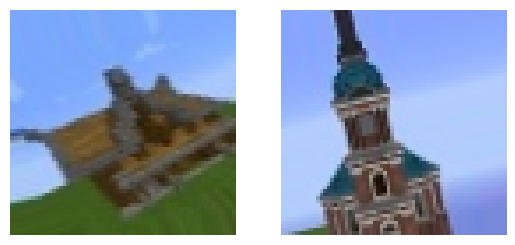

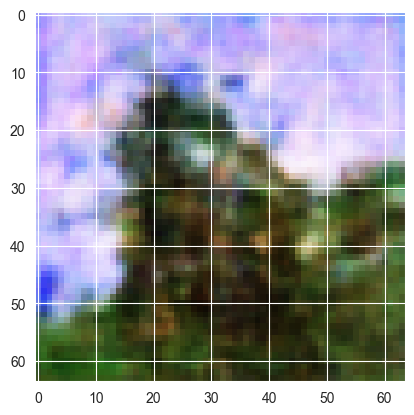

In [30]:
with torch.no_grad():
  # Plot the decoded images in a 2 by 5 grid, with the original images on top of each decoded image


    # Get the first 10 images
    random_images_train_0 = training_dataloader.dataset[5].unsqueeze(0).float().to(device)
    random_images_train_5 = training_dataloader.dataset[7].unsqueeze(0).float().to(device)
    print(f"shape : {random_images_train_0.shape}")
    # Encode the whole images
    encoded_train_0, _, _, _ = variational_autoencoder.encoder(random_images_train_0)
    encoded_train_5, _, _, _ = variational_autoencoder.encoder(random_images_train_5)
    sum_0_5 =encoded_train_5 +  encoded_train_0

    decoded_train = variational_autoencoder.decoder(sum_0_5)
    decoded_train = decoded_train.squeeze()
    # Plot the decoded test images


    # Plot the decoded test images
    f, axarr = plt.subplots(1, 2)


    axarr[0].axis('off')
    axarr[1].axis('off')

    random_images_train_0 = random_images_train_0.squeeze()
    random_images_train_5 = random_images_train_5.squeeze()

    # Plot the original images in black and white
    axarr[0].imshow(random_images_train_0.cpu().detach().permute(1, 2, 0))

    axarr[1].imshow(random_images_train_5.cpu().detach().permute(1, 2, 0))

    # Plot the decoded test images
    f, axarr = plt.subplots(1, 1)

    axarr.imshow(decoded_train.cpu().detach().permute(1, 2, 0))
    plt.savefig("sum_0_5.png")
    plt.show()
# save decoded_train in a file




In [ ]:
!pip install -q optuna

In [ ]:
# lets use optuna to find the best hyperparameters
import optuna
from optuna.trial import TrialState

def define_model(trial):
    # create the Variational Autoencoder
    hidden_dim = 256
    latent_size = trial.suggest_int('latent_size', 2, 200)

    model = VariationalAutoEncoder(input_dim=1,hidden_dim=hidden_dim, latent_dim=latent_size)
    return model



def objective(trial):
    # Generate the model.
    model = define_model(trial).to(device)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam"])

    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    k1 =1
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    k2 = trial.suggest_float('k2', 1e-5, 1)
    # Training of the model.
    for epoch in range(20):
        epoch_loss = 0
        model.train()
        for images, _ in mnist_trainloader:
            images = images.to(device)
            x, mu, sigma, original_x = model(images)
            original_x = original_x.detach()
            loss = loss_function(x, original_x, mu, sigma,k1=k1,k2=k2)

            epoch_loss += loss.mean().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        trial.report(epoch_loss, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return epoch_loss/len(mnist_trainloader.dataset)

In [ ]:

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))